# Entrainement et evaluation des modeles ML - Prediction Crypto

Ce notebook entraine et compare plusieurs modeles de machine learning pour predire le prix de cloture (close) des cryptomonnaies BTC, ETH et SOL a l'horizon t+1 (prochaine periode de 5 minutes).

**Modeles testes :**
- Modeles lineaires : Linear Regression, Ridge, Lasso
- Ensembles d'arbres : Random Forest, XGBoost, LightGBM, CatBoost
- Deep Learning : LSTM, GRU (si TensorFlow est disponible)

Chaque modele est entraine dans deux configurations :
1. **Default** : parametres par defaut
2. **Tuned** : hyperparametres optimises (GridSearch ou manuels)

**Plan du notebook :**
1. Imports et configuration
2. Chargement des donnees
3. Feature engineering
4. Preparation X / y
5. Entrainement des modeles classiques (default puis tuned)
6. Entrainement LSTM / GRU (default puis tuned)
7. Comparaison globale et dashboard
8. Resume

---
## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Deep learning (optionnel)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.optimizers import Adam
    KERAS_AVAILABLE = True
    print("TensorFlow disponible")
except ImportError:
    KERAS_AVAILABLE = False
    print("TensorFlow non disponible, LSTM/GRU ne seront pas entraines")

# Repertoires de sortie
os.makedirs('images/training', exist_ok=True)
os.makedirs('datasets', exist_ok=True)

TensorFlow disponible


---
## 2. Chargement des donnees et formatage des données

In [20]:
df = pd.read_csv("bq-results-20260213-201914-1771013997376.csv", parse_dates=["timestamp"])

In [ ]:
colonnes_a_supprimer = ['source', 'ingestion_timestamp', 'date', 'hour', 'day_of_week']
colonnes_existantes = [col for col in colonnes_a_supprimer if col in df.columns]
print(f"Colonnes à supprimer: {colonnes_existantes}")


Colonnes à supprimer: ['source', 'ingestion_timestamp', 'date', 'hour', 'day_of_week']


In [22]:
df = df.drop(columns=colonnes_existantes)

In [23]:
# Extraire les features temporelles
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0=Lundi, 6=Dimanche
df['day_of_month'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month

# Features cycliques pour heure (car 23h est proche de 0h)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Features cycliques pour jour de semaine
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df = df.sort_values('timestamp').reset_index(drop=True)

In [24]:
df['symbol'].value_counts()

symbol
BTCUSDT    236
SOLUSDT    236
ETHUSDT    236
Name: count, dtype: int64

In [34]:
print(f"Lignes restantes: {len(df)}")


Lignes restantes: 708


In [25]:
df.isnull().sum()

timestamp        0
symbol           0
open             0
high             0
low              0
close            0
volume           0
trades           0
sma_20          84
ema_50          84
rsi_14          84
macd            84
macd_signal     84
bb_upper        84
bb_middle       84
bb_lower        84
hour             0
day_of_week      0
day_of_month     0
month            0
hour_sin         0
hour_cos         0
day_sin          0
day_cos          0
dtype: int64

In [ ]:
datasets = {}

In [ ]:
df_btc = df[df['symbol'] == 'BTCUSDT'].copy().reset_index(drop=True)
df_eth = df[df['symbol'] == 'ETHUSDT'].copy().reset_index(drop=True)
df_sol = df[df['symbol'] == 'SOLUSDT'].copy().reset_index(drop=True)

In [27]:
print(f"\Dataset BTC: {df_btc.shape[0]} lignes X {df_btc.shape[1]} colonnes")
print(f"Periode: {df_btc['timestamp'].min()} -> {df_btc['timestamp'].max()}")

print(f"Dataset ETH: {df_eth.shape[0]} lignes X {df_eth.shape[1]} colonnes")
print(f"Periode: {df_eth['timestamp'].min()} -> {df_eth['timestamp'].max()}")

print(f"Dataset SOL: {df_sol.shape[0]} lignes X {df_sol.shape[1]} colonnes")
print(f"Periode: {df_sol['timestamp'].min()} -> {df_sol['timestamp'].max()}")

\Dataset BTC: 236 lignes X 24 colonnes
Periode: 2026-02-13 00:00:00+00:00 -> 2026-02-13 20:05:00+00:00
Dataset ETH: 236 lignes X 24 colonnes
Periode: 2026-02-13 00:00:00+00:00 -> 2026-02-13 20:05:00+00:00
Dataset SOL: 236 lignes X 24 colonnes
Periode: 2026-02-13 00:00:00+00:00 -> 2026-02-13 20:05:00+00:00


In [28]:
# Supprimer la colonne 'symbol' car elle n'est plus nécessaire
df_btc = df_btc.drop(columns=['symbol'])
df_eth = df_eth.drop(columns=['symbol'])
df_sol = df_sol.drop(columns=['symbol'])

---
### DIVISION TRAIN/TEST TEMPORELLE (70/30)

In [29]:
def split_temporal_data(df, train_ratio=0.7, crypto_name=''):
    # Calculer l'index de séparation
    split_idx = int(len(df) * train_ratio)
    
    # Division temporelle (pas de shuffle!)
    train = df.iloc[:split_idx].copy()
    test = df.iloc[split_idx:].copy()
    
    print(f"{crypto_name}")
    print(f"Total: {len(df)} lignes")
    print(f"Train: {len(train)} lignes ({len(train)/len(df)*100:.1f}%)")
    print(f"Test:  {len(test)} lignes ({len(test)/len(df)*100:.1f}%)")
    print(f"Train période: {train['timestamp'].min()} -> {train['timestamp'].max()}")
    print(f"Test période:  {test['timestamp'].min()} -> {test['timestamp'].max()}")
    
    return train, test



# Division pour BTC
btc_train, btc_test = split_temporal_data(df_btc, train_ratio=0.7, crypto_name='BTC')

# Division pour ETH
eth_train, eth_test = split_temporal_data(df_eth, train_ratio=0.7, crypto_name='ETH')

# Division pour SOL
sol_train, sol_test = split_temporal_data(df_sol, train_ratio=0.7, crypto_name='SOL')

BTC
Total: 236 lignes
Train: 165 lignes (69.9%)
Test:  71 lignes (30.1%)
Train période: 2026-02-13 00:00:00+00:00 -> 2026-02-13 13:40:00+00:00
Test période:  2026-02-13 13:45:00+00:00 -> 2026-02-13 20:05:00+00:00
ETH
Total: 236 lignes
Train: 165 lignes (69.9%)
Test:  71 lignes (30.1%)
Train période: 2026-02-13 00:00:00+00:00 -> 2026-02-13 13:40:00+00:00
Test période:  2026-02-13 13:45:00+00:00 -> 2026-02-13 20:05:00+00:00
SOL
Total: 236 lignes
Train: 165 lignes (69.9%)
Test:  71 lignes (30.1%)
Train période: 2026-02-13 00:00:00+00:00 -> 2026-02-13 13:40:00+00:00
Test période:  2026-02-13 13:45:00+00:00 -> 2026-02-13 20:05:00+00:00


In [30]:
datasets = {
   'btc':{
       'train':btc_train,
       'test':btc_test
   }, 
    'eth':{
       'train':eth_train,
       'test':eth_test
   }, 
   'sol':{
       'train':sol_train,
       'test':sol_test
   }
}

In [32]:
for name in ['btc', 'eth', 'sol']:
    tr, te = datasets[name]['train'], datasets[name]['test']
    print(f"{name.upper()} - Train: {tr.shape}, Test: {te.shape}")

BTC - Train: (165, 23), Test: (71, 23)
ETH - Train: (165, 23), Test: (71, 23)
SOL - Train: (165, 23), Test: (71, 23)


---
## 3. Feature engineering

On enrichit les donnees avec des features de lag (valeurs passees), des moyennes mobiles et des indicateurs de variation. Ces features permettent aux modeles de capturer la dynamique temporelle du marche.

In [33]:
def create_lag_features(df, n_lags=12):
    """
    Cree des features de lag et rolling.
    n_lags=12 correspond a 1 heure de donnees (12 x 5 min).
    """
    df = df.copy()

    for i in range(1, n_lags + 1):
        df[f'close_lag_{i}'] = df['close'].shift(i)

    for i in range(1, 4):
        df[f'volume_lag_{i}'] = df['volume'].shift(i)

    df['close_rolling_mean_5'] = df['close'].rolling(5).mean()
    df['close_rolling_mean_20'] = df['close'].rolling(20).mean()
    df['close_rolling_std_20'] = df['close'].rolling(20).std()

    df['price_change'] = df['close'].diff()
    df['price_change_pct'] = df['close'].pct_change() * 100
    df['volume_change'] = df['volume'].diff()

    df['hl_spread'] = df['high'] - df['low']
    df['hl_spread_pct'] = (df['hl_spread'] / df['close']) * 100

    return df


for name in datasets:
    datasets[name]['train'] = create_lag_features(datasets[name]['train']).dropna().reset_index(drop=True)
    datasets[name]['test'] = create_lag_features(datasets[name]['test']).dropna().reset_index(drop=True)

for name in datasets:
    tr, te = datasets[name]['train'], datasets[name]['test']
    print(f"{name.upper()} apres feature engineering - Train: {tr.shape}, Test: {te.shape}")

BTC apres feature engineering - Train: (146, 46), Test: (24, 46)
ETH apres feature engineering - Train: (146, 46), Test: (24, 46)
SOL apres feature engineering - Train: (146, 46), Test: (24, 46)


---
## 4. Preparation X / y

La target est le prix de cloture de la periode suivante (t+1). Les features sont normalisees avec StandardScaler.

In [35]:
def prepare_data_for_ml(train_df, test_df):
    exclude_cols = ['timestamp', 'close']
    feature_cols = [c for c in train_df.columns if c not in exclude_cols]

    y_train = train_df['close'].shift(-1).iloc[:-1]
    y_test = test_df['close'].shift(-1).iloc[:-1]

    X_train = train_df[feature_cols].iloc[:-1]
    X_test = test_df[feature_cols].iloc[:-1]

    ts_train = train_df['timestamp'].iloc[:-1]
    ts_test = test_df['timestamp'].iloc[:-1]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, ts_train, ts_test, scaler, feature_cols


ml_data = {}
for name in datasets:
    ml_data[name] = prepare_data_for_ml(datasets[name]['train'], datasets[name]['test'])
    X_tr, X_te = ml_data[name][0], ml_data[name][1]
    print(f"{name.upper()} - X_train: {X_tr.shape}, X_test: {X_te.shape}, features: {X_tr.shape[1]}")

BTC - X_train: (145, 44), X_test: (23, 44), features: 44
ETH - X_train: (145, 44), X_test: (23, 44), features: 44
SOL - X_train: (145, 44), X_test: (23, 44), features: 44


---
## 5. Fonctions utilitaires

Fonctions partagees pour l'evaluation et la visualisation des predictions.

In [36]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calcule MAE, RMSE, R2 et MAPE."""
    return {
        'Model': model_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
    }


def plot_predictions(timestamps, y_true, y_pred, title, filename):
    """Trace predictions vs reel + erreurs, et sauvegarde dans images/training/."""
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    axes[0].plot(timestamps, y_true, label='Reel', color='blue', linewidth=2, alpha=0.8)
    axes[0].plot(timestamps, y_pred, label='Prediction', color='red', linewidth=2, alpha=0.8, linestyle='--')
    axes[0].set_title(title, fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Prix (USD)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    errors = np.asarray(y_true) - np.asarray(y_pred)
    axes[1].plot(timestamps, errors, color='purple', linewidth=1, alpha=0.7)
    axes[1].axhline(y=0, color='black', linewidth=1)
    axes[1].fill_between(timestamps, errors, 0, where=(errors > 0), color='green', alpha=0.3, label='Sous-estimation')
    axes[1].fill_between(timestamps, errors, 0, where=(errors < 0), color='red', alpha=0.3, label='Sur-estimation')
    axes[1].set_title('Erreurs de prediction', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Erreur (USD)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'images/training/{filename}', dpi=300, bbox_inches='tight')
    plt.close()

---
## 6. Entrainement des modeles classiques (default)

On entraine les 7 modeles classiques avec leurs parametres par defaut pour etablir une baseline.

In [ ]:
def get_default_models():
    """Retourne un dictionnaire de modeles avec parametres par defaut."""
    return {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1),
        'CatBoost': CatBoostRegressor(iterations=100, random_state=42, verbose=0),
    }


def train_all_models(models_dict, X_train, X_test, y_train, y_test, ts_test, crypto_name, suffix='default'):
    """Entraine tous les modeles et retourne les resultats et modeles entraines."""
    results = []
    trained = {}

    for name, model in models_dict.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        label = f"{name} ({suffix.capitalize()})" if suffix != 'default' else name
        metrics = evaluate_model(y_test, y_pred, label)
        results.append(metrics)
        trained[name] = model

        plot_predictions(
            ts_test, y_test, y_pred,
            f'{crypto_name} - {label}',
            f'{crypto_name.lower()}_{name.lower().replace(" ", "_")}_{suffix}.png'
        )

    return results, trained


results_default = {}
models_default = {}

for name in ['btc', 'eth', 'sol']:
    X_tr, X_te, y_tr, y_te, ts_tr, ts_te, scaler, feats = ml_data[name]
    print(f"--- {name.upper()} (default) ---")
    res, mdls = train_all_models(get_default_models(), X_tr, X_te, y_tr, y_te, ts_te, name.upper())
    results_default[name.upper()] = res
    models_default[name.upper()] = mdls


--- BTC (default) ---

--- ETH (default) ---

--- SOL (default) ---


### Resultats default

In [ ]:
for crypto in ['BTC', 'ETH', 'SOL']:
    print(f"--- {crypto} ---")
    df_res = pd.DataFrame(results_default[crypto]).sort_values('R2', ascending=False)
    display(df_res)


--- BTC ---


,Model,MAE,RMSE,R2,MAPE
0,Linear Regression,169.025669,237.532063,-0.236118,0.245291
1,Ridge,216.294843,289.285885,-0.833453,0.313696
2,Lasso,269.648950,340.844351,-1.545233,0.390885
4,XGBoost,1481.394878,1496.721924,-48.079210,2.147875
5,LightGBM,1696.924599,1708.951579,-62.984509,2.460570
3,Random Forest,1695.744183,1716.350967,-63.539786,2.458601
6,CatBoost,1754.480665,1771.542057,-67.757212,2.543897



--- ETH ---


,Model,MAE,RMSE,R2,MAPE
1,Ridge,15.420802,16.892137,-1.030354,0.751935
2,Lasso,16.035609,17.928991,-1.287254,0.781388
0,Linear Regression,20.338537,25.103219,-3.483957,0.991488
3,Random Forest,77.531439,78.438450,-42.778476,3.778609
4,XGBoost,77.598098,78.499044,-42.846141,3.781870
6,CatBoost,78.846866,79.726753,-44.228356,3.842808
5,LightGBM,81.061173,81.931451,-46.764357,3.950784



--- SOL ---


,Model,MAE,RMSE,R2,MAPE
1,Ridge,0.750664,0.843268,-2.194185,0.895158
0,Linear Regression,0.948199,1.102359,-4.458512,1.130390
3,Random Forest,3.651274,3.681498,-59.880404,4.352344
5,LightGBM,3.706057,3.735168,-61.668416,4.417730
4,XGBoost,3.745985,3.775942,-63.044074,4.465295
6,CatBoost,3.780044,3.808879,-64.166260,4.505976
2,Lasso,4.556396,4.580760,-93.254814,5.432028


---
## 7. Entrainement des modeles classiques (tuned)

On optimise les hyperparametres via GridSearchCV pour Ridge, Lasso et Random Forest, et on utilise des parametres manuellement choisis pour les modeles de boosting.

In [ ]:
def get_tuned_models(X_train, y_train):
    # Ridge
    ridge_grid = GridSearchCV(
        Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100]},
        cv=3, scoring='neg_mean_squared_error', n_jobs=-1
    )
    ridge_grid.fit(X_train, y_train)

    # Lasso
    lasso_grid = GridSearchCV(
        Lasso(), {'alpha': [0.01, 0.1, 1, 10]},
        cv=3, scoring='neg_mean_squared_error', n_jobs=-1
    )
    lasso_grid.fit(X_train, y_train)

    # Random Forest
    rf_grid = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]},
        cv=3, scoring='neg_mean_squared_error', n_jobs=-1
    )
    rf_grid.fit(X_train, y_train)

    print(f"Ridge best alpha: {ridge_grid.best_params_['alpha']}")
    print(f"Lasso best alpha: {lasso_grid.best_params_['alpha']}")
    print(f"RF best params: {rf_grid.best_params_}")

    return {
        'Linear Regression': LinearRegression(),
        'Ridge': ridge_grid.best_estimator_,
        'Lasso': lasso_grid.best_estimator_,
        'Random Forest': rf_grid.best_estimator_,
        'XGBoost': xgb.XGBRegressor(
            n_estimators=200, max_depth=7, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
        ),
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=200, max_depth=7, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, verbose=-1
        ),
        'CatBoost': CatBoostRegressor(
            iterations=200, depth=7, learning_rate=0.1, random_state=42, verbose=0
        ),
    }


results_tuned = {}
models_tuned = {}

for name in ['btc', 'eth', 'sol']:
    X_tr, X_te, y_tr, y_te, ts_tr, ts_te, scaler, feats = ml_data[name]
    print(f"--- {name.upper()} (tuned) ---")
    tuned_models = get_tuned_models(X_tr, y_tr)
    res, mdls = train_all_models(tuned_models, X_tr, X_te, y_tr, y_te, ts_te, name.upper(), suffix='tuned')
    results_tuned[name.upper()] = res
    models_tuned[name.upper()] = mdls


--- BTC (tuned) ---
  Ridge best alpha: 10
  Lasso best alpha: 1
  RF best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}

--- ETH (tuned) ---
  Ridge best alpha: 10
  Lasso best alpha: 0.1
  RF best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

--- SOL (tuned) ---
  Ridge best alpha: 10
  Lasso best alpha: 0.01
  RF best params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


### Resultats tuned

In [41]:
for crypto in ['BTC', 'ETH', 'SOL']:
    print(f"--- {crypto} ---")
    df_res = pd.DataFrame(results_tuned[crypto]).sort_values('R2', ascending=False)
    display(df_res)

--- BTC ---


,Model,MAE,RMSE,R2,MAPE
0,Linear Regression (Tuned),169.025669,237.532063,-0.236118,0.245291
1,Ridge (Tuned),262.528644,331.747122,-1.411180,0.380553
2,Lasso (Tuned),269.648950,340.844351,-1.545233,0.390885
4,XGBoost (Tuned),1580.400312,1598.678376,-54.993489,2.291376
5,LightGBM (Tuned),1671.890526,1683.977046,-61.128041,2.424264
3,Random Forest (Tuned),1695.744183,1716.350967,-63.539786,2.458601
6,CatBoost (Tuned),1805.122682,1820.223691,-71.588003,2.617401


--- ETH ---


,Model,MAE,RMSE,R2,MAPE
2,Lasso (Tuned),13.025289,14.686266,-0.534707,0.634671
1,Ridge (Tuned),17.162076,18.469985,-1.427369,0.836702
0,Linear Regression (Tuned),20.338537,25.103219,-3.483957,0.991488
4,XGBoost (Tuned),77.083190,77.919647,-42.201278,3.756905
3,Random Forest (Tuned),79.132104,80.017138,-44.558421,3.856696
5,LightGBM (Tuned),79.627179,80.521374,-45.134412,3.880818
6,CatBoost (Tuned),80.946640,81.819431,-46.633835,3.945200


--- SOL ---


,Model,MAE,RMSE,R2,MAPE
2,Lasso (Tuned),0.523315,0.649636,-0.895694,0.623515
1,Ridge (Tuned),0.662458,0.762392,-1.610871,0.789815
0,Linear Regression (Tuned),0.948199,1.102359,-4.458512,1.130390
3,Random Forest (Tuned),3.651700,3.681718,-59.887663,4.352861
5,LightGBM (Tuned),3.695218,3.724168,-61.299836,4.404814
4,XGBoost (Tuned),3.742064,3.771291,-62.886397,4.460657
6,CatBoost (Tuned),3.970091,4.000526,-70.889007,4.732514


### Comparaison default vs tuned

In [42]:
comparison_data = []

for crypto in ['BTC', 'ETH', 'SOL']:
    df_def = pd.DataFrame(results_default[crypto])
    df_tun = pd.DataFrame(results_tuned[crypto])

    for i in range(len(df_def)):
        model_base = df_def.iloc[i]['Model']
        comparison_data.append({
            'Crypto': crypto,
            'Model': model_base,
            'R2 Default': round(df_def.iloc[i]['R2'], 4),
            'R2 Tuned': round(df_tun.iloc[i]['R2'], 4),
            'Delta R2': round(df_tun.iloc[i]['R2'] - df_def.iloc[i]['R2'], 4),
            'RMSE Default': round(df_def.iloc[i]['RMSE'], 2),
            'RMSE Tuned': round(df_tun.iloc[i]['RMSE'], 2),
        })

df_comparison = pd.DataFrame(comparison_data)

for crypto in ['BTC', 'ETH', 'SOL']:
    print(f"--- {crypto} ---")
    display(df_comparison[df_comparison['Crypto'] == crypto])

--- BTC ---


,Crypto,Model,R2 Default,R2 Tuned,Delta R2,RMSE Default,RMSE Tuned
0,BTC,Linear Regression,-0.2361,-0.2361,0.0000,237.53,237.53
1,BTC,Ridge,-0.8335,-1.4112,-0.5777,289.29,331.75
2,BTC,Lasso,-1.5452,-1.5452,0.0000,340.84,340.84
3,BTC,Random Forest,-63.5398,-63.5398,0.0000,1716.35,1716.35
4,BTC,XGBoost,-48.0792,-54.9935,-6.9143,1496.72,1598.68
5,BTC,LightGBM,-62.9845,-61.1280,1.8565,1708.95,1683.98
6,BTC,CatBoost,-67.7572,-71.5880,-3.8308,1771.54,1820.22


--- ETH ---


,Crypto,Model,R2 Default,R2 Tuned,Delta R2,RMSE Default,RMSE Tuned
7,ETH,Linear Regression,-3.4840,-3.4840,0.0000,25.10,25.10
8,ETH,Ridge,-1.0304,-1.4274,-0.3970,16.89,18.47
9,ETH,Lasso,-1.2873,-0.5347,0.7525,17.93,14.69
10,ETH,Random Forest,-42.7785,-44.5584,-1.7799,78.44,80.02
11,ETH,XGBoost,-42.8461,-42.2013,0.6449,78.50,77.92
12,ETH,LightGBM,-46.7644,-45.1344,1.6299,81.93,80.52
13,ETH,CatBoost,-44.2284,-46.6338,-2.4055,79.73,81.82


--- SOL ---


,Crypto,Model,R2 Default,R2 Tuned,Delta R2,RMSE Default,RMSE Tuned
14,SOL,Linear Regression,-4.4585,-4.4585,0.0000,1.10,1.10
15,SOL,Ridge,-2.1942,-1.6109,0.5833,0.84,0.76
16,SOL,Lasso,-93.2548,-0.8957,92.3591,4.58,0.65
17,SOL,Random Forest,-59.8804,-59.8877,-0.0073,3.68,3.68
18,SOL,XGBoost,-63.0441,-62.8864,0.1577,3.78,3.77
19,SOL,LightGBM,-61.6684,-61.2998,0.3686,3.74,3.72
20,SOL,CatBoost,-64.1663,-70.8890,-6.7227,3.81,4.00


---
## 8. Entrainement LSTM / GRU

Les modeles LSTM et GRU sont des reseaux de neurones recurrents adaptes aux series temporelles. Ils prennent en entree des sequences de N pas de temps passes pour predire la valeur suivante.

On utilise des sequences de 60 pas (= 5 heures de donnees a 5 min).

In [43]:
if not KERAS_AVAILABLE:
    print("TensorFlow non disponible, cette section est ignoree.")
else:
    N_STEPS = 60

    def create_sequences(train_df, test_df, n_steps=N_STEPS):
        """
        Cree des sequences temporelles pour LSTM/GRU.
        Retourne les sequences train et test, les timestamps test, et les scalers.
        """
        feature_cols = [c for c in train_df.columns if c != 'timestamp']

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train_raw = scaler_X.fit_transform(train_df[feature_cols].values)
        y_train_raw = scaler_y.fit_transform(train_df['close'].values.reshape(-1, 1))

        X_test_raw = scaler_X.transform(test_df[feature_cols].values)
        y_test_raw = scaler_y.transform(test_df['close'].values.reshape(-1, 1))

        def _make_seq(X, y, timestamps):
            Xs, ys, ts = [], [], []
            for i in range(n_steps, len(X)):
                Xs.append(X[i - n_steps:i])
                ys.append(y[i])
                ts.append(timestamps.iloc[i])
            return np.array(Xs), np.array(ys), ts

        X_train_seq, y_train_seq, _ = _make_seq(X_train_raw, y_train_raw, train_df['timestamp'])
        X_test_seq, y_test_seq, ts_test = _make_seq(X_test_raw, y_test_raw, test_df['timestamp'])

        return X_train_seq, y_train_seq, X_test_seq, y_test_seq, ts_test, scaler_y


    seq_data = {}
    for name in ['btc', 'eth', 'sol']:
        seq_data[name] = create_sequences(datasets[name]['train'], datasets[name]['test'])
        X_tr_s = seq_data[name][0]
        X_te_s = seq_data[name][2]
        print(f"{name.upper()} - Train seq: {X_tr_s.shape}, Test seq: {X_te_s.shape}")

BTC - Train seq: (86, 60, 45), Test seq: (0,)
ETH - Train seq: (86, 60, 45), Test seq: (0,)
SOL - Train seq: (86, 60, 45), Test seq: (0,)


---
## 9. Dashboard de comparaison globale

On rassemble les resultats de tous les modeles (classiques + deep learning, default + tuned) dans un tableau et un dashboard visuel.

In [47]:
# Construire le tableau recapitulatif complet
model_names_classic = ['Linear Regression', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']

recap_rows = []

for crypto in ['BTC', 'ETH', 'SOL']:
    df_def = pd.DataFrame(results_default[crypto])
    df_tun = pd.DataFrame(results_tuned[crypto])

    for i in range(len(df_def)):
        recap_rows.append({
            'Crypto': crypto,
            'Modele': df_def.iloc[i]['Model'],
            'R2 Default': round(df_def.iloc[i]['R2'], 4),
            'R2 Tuned': round(df_tun.iloc[i]['R2'], 4),
            'MAE Tuned': round(df_tun.iloc[i]['MAE'], 2),
            'RMSE Tuned': round(df_tun.iloc[i]['RMSE'], 2),
        })


df_recap = pd.DataFrame(recap_rows)

for crypto in ['BTC', 'ETH', 'SOL']:
    print(f"--- {crypto} ---")
    display(df_recap[df_recap['Crypto'] == crypto].sort_values('R2 Tuned', ascending=False))

# Sauvegarder
df_recap.to_csv('datasets/results_summary_all_models.csv', index=False)
print("Tableau sauvegarde dans datasets/results_summary_all_models.csv")

--- BTC ---


,Crypto,Modele,R2 Default,R2 Tuned,MAE Tuned,RMSE Tuned
0,BTC,Linear Regression,-0.2361,-0.2361,169.03,237.53
1,BTC,Ridge,-0.8335,-1.4112,262.53,331.75
2,BTC,Lasso,-1.5452,-1.5452,269.65,340.84
4,BTC,XGBoost,-48.0792,-54.9935,1580.40,1598.68
5,BTC,LightGBM,-62.9845,-61.1280,1671.89,1683.98
3,BTC,Random Forest,-63.5398,-63.5398,1695.74,1716.35
6,BTC,CatBoost,-67.7572,-71.5880,1805.12,1820.22


--- ETH ---


,Crypto,Modele,R2 Default,R2 Tuned,MAE Tuned,RMSE Tuned
9,ETH,Lasso,-1.2873,-0.5347,13.03,14.69
8,ETH,Ridge,-1.0304,-1.4274,17.16,18.47
7,ETH,Linear Regression,-3.4840,-3.4840,20.34,25.10
11,ETH,XGBoost,-42.8461,-42.2013,77.08,77.92
10,ETH,Random Forest,-42.7785,-44.5584,79.13,80.02
12,ETH,LightGBM,-46.7644,-45.1344,79.63,80.52
13,ETH,CatBoost,-44.2284,-46.6338,80.95,81.82


--- SOL ---


,Crypto,Modele,R2 Default,R2 Tuned,MAE Tuned,RMSE Tuned
16,SOL,Lasso,-93.2548,-0.8957,0.52,0.65
15,SOL,Ridge,-2.1942,-1.6109,0.66,0.76
14,SOL,Linear Regression,-4.4585,-4.4585,0.95,1.10
17,SOL,Random Forest,-59.8804,-59.8877,3.65,3.68
19,SOL,LightGBM,-61.6684,-61.2998,3.70,3.72
18,SOL,XGBoost,-63.0441,-62.8864,3.74,3.77
20,SOL,CatBoost,-64.1663,-70.8890,3.97,4.00


Tableau sauvegarde dans datasets/results_summary_all_models.csv


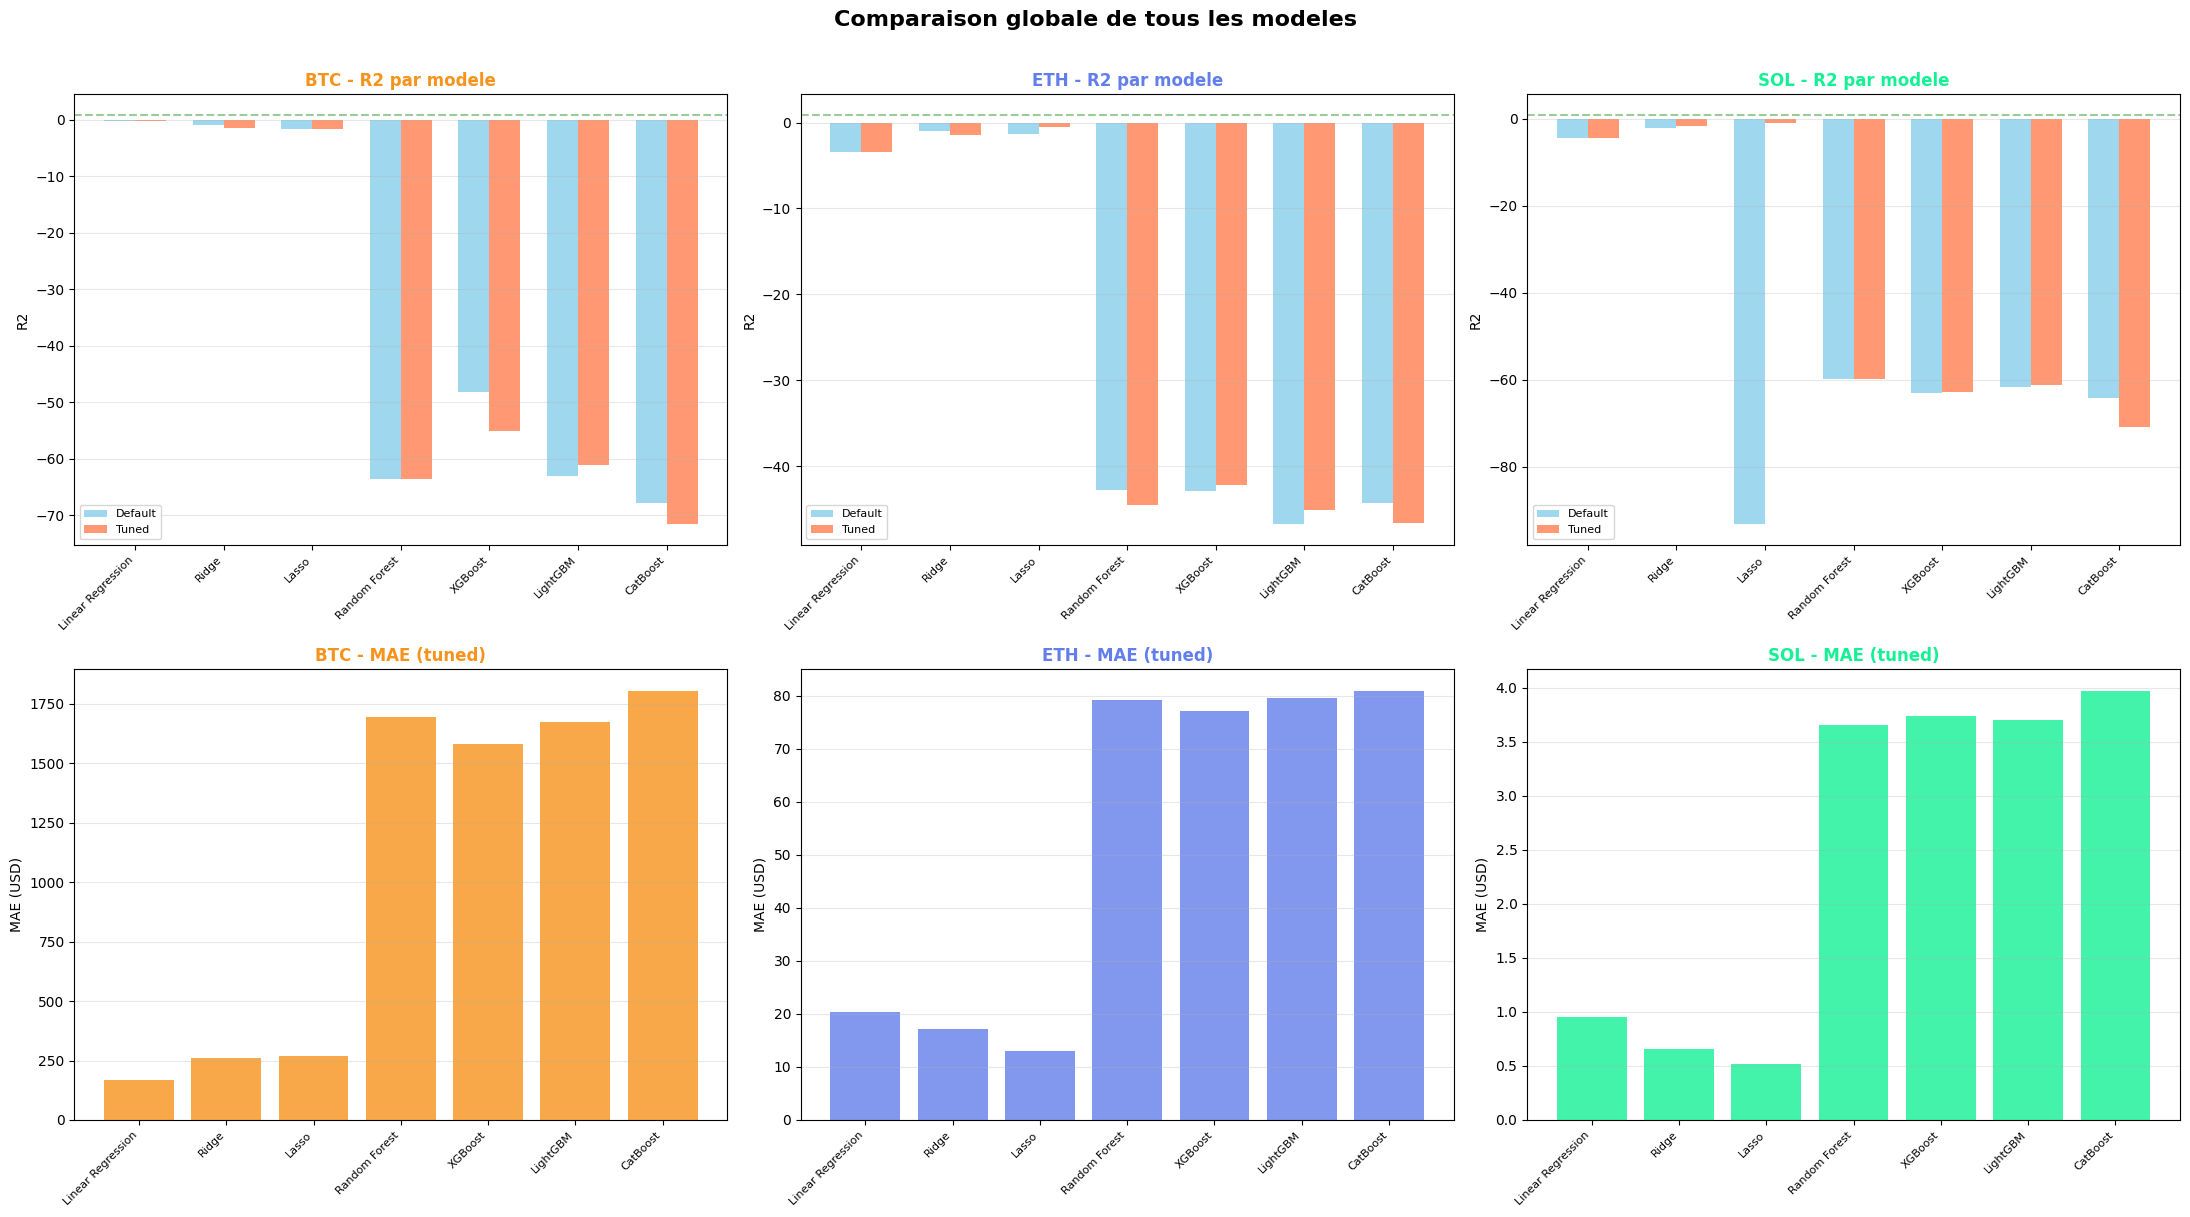

In [48]:
# Dashboard visuel
colors_crypto = {'BTC': '#F7931A', 'ETH': '#627EEA', 'SOL': '#14F195'}
all_models = df_recap['Modele'].unique()

fig, axes = plt.subplots(2, 3, figsize=(22, 12))

for idx, crypto in enumerate(['BTC', 'ETH', 'SOL']):
    subset = df_recap[df_recap['Crypto'] == crypto]
    x = np.arange(len(subset))
    w = 0.35

    # R2 default vs tuned
    ax = axes[0, idx]
    ax.bar(x - w/2, subset['R2 Default'], w, label='Default', alpha=0.8, color='skyblue')
    ax.bar(x + w/2, subset['R2 Tuned'], w, label='Tuned', alpha=0.8, color='coral')
    ax.set_title(f'{crypto} - R2 par modele', fontsize=12, fontweight='bold', color=colors_crypto[crypto])
    ax.set_xticks(x)
    ax.set_xticklabels(subset['Modele'], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('R2')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.4)

    # MAE tuned
    ax = axes[1, idx]
    ax.bar(x, subset['MAE Tuned'], color=colors_crypto[crypto], alpha=0.8)
    ax.set_title(f'{crypto} - MAE (tuned)', fontsize=12, fontweight='bold', color=colors_crypto[crypto])
    ax.set_xticks(x)
    ax.set_xticklabels(subset['Modele'], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('MAE (USD)')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Comparaison globale de tous les modeles', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('images/training/dashboard_comparison_global.png', dpi=300, bbox_inches='tight')
plt.show()

### Heatmap des performances R2 (modeles tuned)

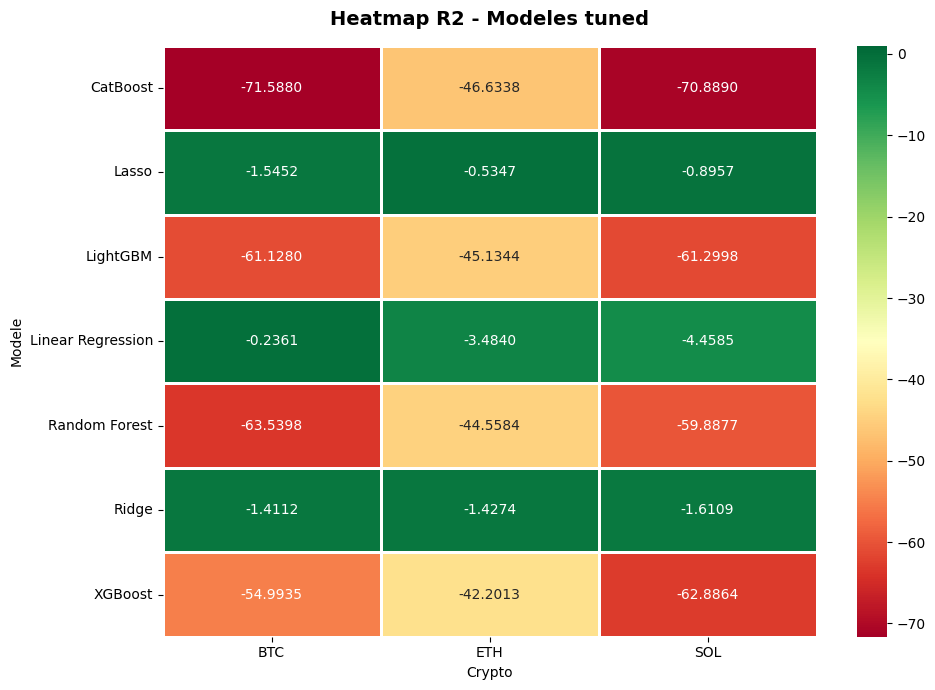

In [49]:
heatmap_data = df_recap.pivot(index='Modele', columns='Crypto', values='R2 Tuned')
heatmap_data = heatmap_data[['BTC', 'ETH', 'SOL']]

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', fmt='.4f', linewidths=1,
            vmin=heatmap_data.min().min() - 0.05, vmax=1.0)
plt.title('Heatmap R2 - Modeles tuned', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('images/training/heatmap_r2_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

### Amelioration default vers tuned

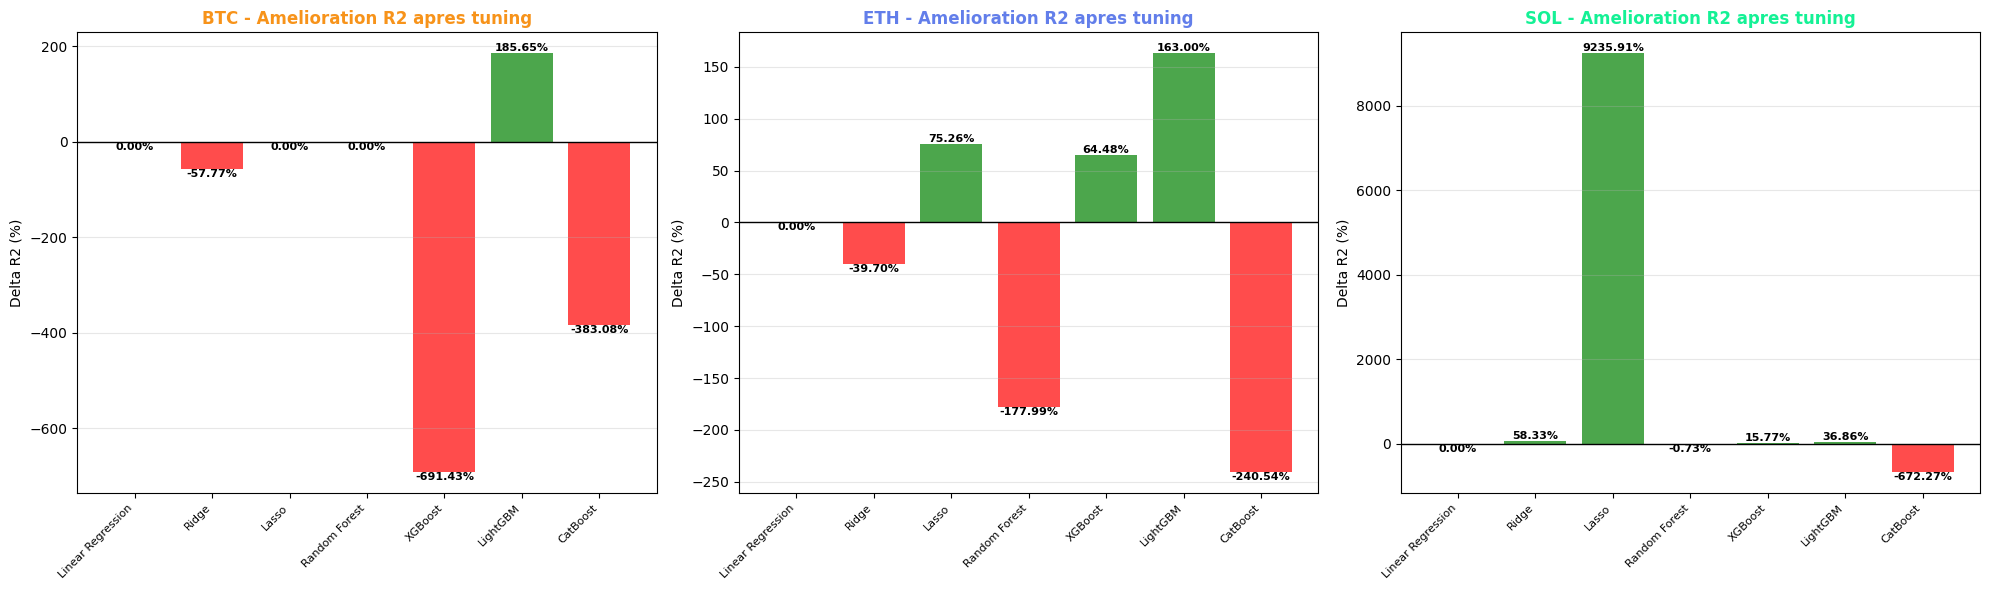

In [50]:
df_recap['Delta R2'] = df_recap['R2 Tuned'] - df_recap['R2 Default']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, crypto in enumerate(['BTC', 'ETH', 'SOL']):
    subset = df_recap[df_recap['Crypto'] == crypto]
    x = np.arange(len(subset))
    improvements = subset['Delta R2'].values * 100
    bar_colors = ['green' if v > 0 else 'red' for v in improvements]

    ax = axes[idx]
    bars = ax.bar(x, improvements, color=bar_colors, alpha=0.7)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_title(f'{crypto} - Amelioration R2 apres tuning', fontsize=12, fontweight='bold', color=colors_crypto[crypto])
    ax.set_xticks(x)
    ax.set_xticklabels(subset['Modele'], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Delta R2 (%)')
    ax.grid(True, alpha=0.3, axis='y')

    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h,
                f'{h:.2f}%', ha='center', va='bottom' if h > 0 else 'top', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('images/training/improvement_default_to_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 10. Resume

### Meilleurs modeles par crypto

In [51]:
for crypto in ['BTC', 'ETH', 'SOL']:
    subset = df_recap[df_recap['Crypto'] == crypto].sort_values('R2 Tuned', ascending=False)
    best = subset.iloc[0]
    print(f"{crypto} : {best['Modele']} -> R2={best['R2 Tuned']:.4f}, MAE={best['MAE Tuned']:.2f}, RMSE={best['RMSE Tuned']:.2f}")

print(f"Amelioration moyenne apres tuning : {df_recap['Delta R2'].mean()*100:+.2f}%")

BTC : Linear Regression -> R2=-0.2361, MAE=169.03, RMSE=237.53
ETH : Lasso -> R2=-0.5347, MAE=13.03, RMSE=14.69
SOL : Lasso -> R2=-0.8957, MAE=0.52, RMSE=0.65
Amelioration moyenne apres tuning : +360.56%
